## Feature definition and creation of NPZ files containing the feature matrix, and the target vector for each set.

In [1]:
import numpy as np
import pandas as pd
import import_ipynb
from custom_features import get_all_features
from custom_features import get_pswm  

In [2]:
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")

# 5-cross-validation run: for each run i, testing set=i, validation set=((i)%5)+1, training sets = remaining i sets

for i in range(1,6): #iteration on the sets 
    training_sets=((((i +1)%5)+1),(((i+2)%5)+1),(((i+3)%5)+1)) 
    testing = dataset.query(f"Set=='{i}'")
    validation = dataset.query(f"Set=='{((i)%5)+1}'")
    training = dataset.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")

    print("-"*100)
    print("testing set: ",i)
    print("validation set: ", ((i)%5)+1)
    print("training sets: ",training_sets)

    
    #TRAINING
    matrix_training = get_pswm(training , 13 , 2)
    feature_set_training , feature_order_training = get_all_features(training["Sequence"] , matrix_training, 15 )
    
    # create the target vector:
    vector_neg_pos = training["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_training_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'training_features_{i}.npz', matrix=feature_set_training, target=target_training_vector)

    #VALIDATION
    feature_set_validation , feature_order_validation = get_all_features(validation["Sequence"] , matrix_training, 15 )
 
    
    # create the target vector:
    vector_neg_pos = validation["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_validation_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'validation_features_{i}.npz', matrix=feature_set_validation, target=target_validation_vector)

    #TESTING
    feature_set_testing , feature_order_testing = get_all_features(testing["Sequence"] , matrix_training, 15 )
    
    # create the target vector:
    vector_neg_pos = testing["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_testing_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'testing_features_{i}.npz', matrix=feature_set_testing, target=target_testing_vector)

    #now we have created a file for each set, for that iteration

----------------------------------------------------------------------------------------------------
testing set:  1
validation set:  2
training sets:  (3, 4, 5)
----------------------------------------------------------------------------------------------------
testing set:  2
validation set:  3
training sets:  (4, 5, 1)
----------------------------------------------------------------------------------------------------
testing set:  3
validation set:  4
training sets:  (5, 1, 2)
----------------------------------------------------------------------------------------------------
testing set:  4
validation set:  5
training sets:  (1, 2, 3)
----------------------------------------------------------------------------------------------------
testing set:  5
validation set:  1
training sets:  (2, 3, 4)


## Feature selection with random forest and SVM training

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef

In [4]:
def performance_on_subset(subset_features, feature_order_training, x_train, y_train, x_val, y_val, pipeline):
    #find the col number of a specific feature
    idx = [feature_order_training.index(f) for f in subset_features]  
    #take the column of the corrispective feature
    Xtr = x_train[:, idx] 
    Xva = x_val[:, idx]
    pipeline.fit(Xtr, y_train)     # train the svm on training data
    y_pred = pipeline.predict(Xva) # predict on validation data
    mcc = matthews_corrcoef(y_val, y_pred) # compute MCC 
    return mcc  # mcc on VALIDATION

Features by Gini importance for 1-th iteration:
               feature  importance
0           VhonHeijne    0.330052
1      tm_tendency_max    0.084350
2                    C    0.055271
3    max_miyazawa_mean    0.039457
4   chou_fasman_h_mean    0.039169
5      flexibility_max    0.026584
6            punta_max    0.021073
7     flexibility_mean    0.020266
8             basicity    0.019020
9     tm_tendency_mean    0.018763
10          punta_mean    0.018323
11                   R    0.017663
12       miyazawa_mean    0.016666
13      bulkiness_mean    0.016573
14   chou_fasman_h_max    0.015111
15    chou_fasma_b_max    0.013260
16                   L    0.013250
17                   T    0.013235
18                   G    0.012900
19          argos_mean    0.012895
20                   D    0.012553
21                   E    0.012389
22           argos_max    0.012207
23   chou_fasma_b_mean    0.012140
24                   S    0.012120
25                   K    0.011634
26     

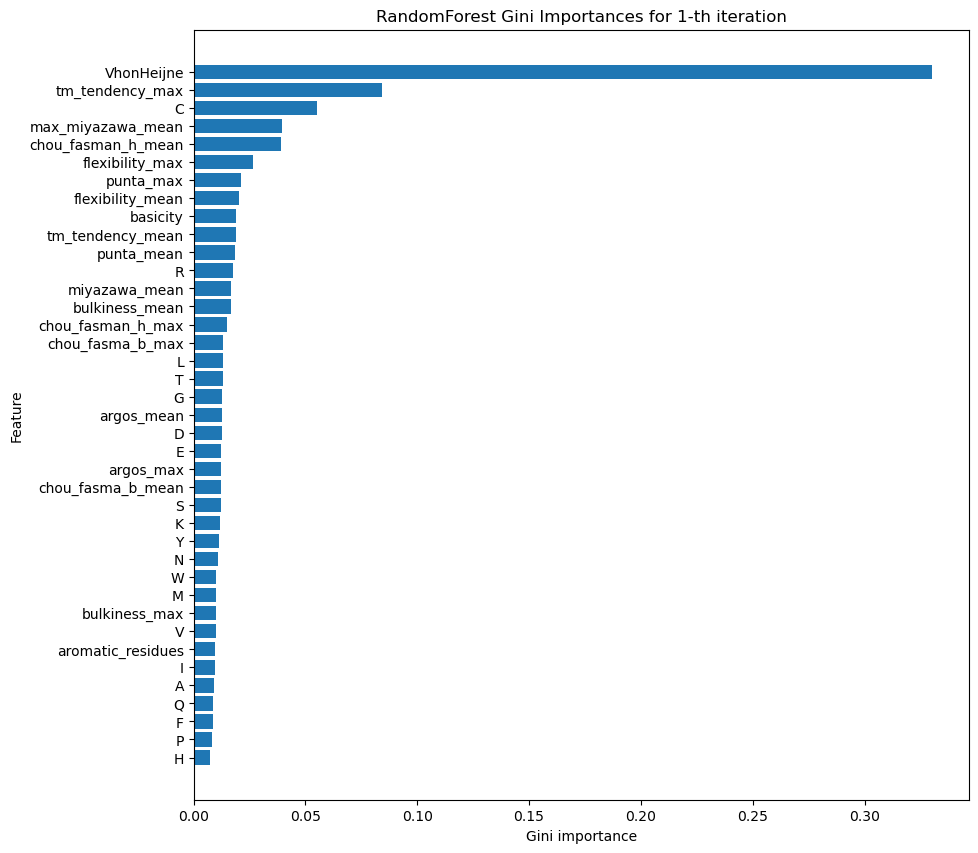

Best k on validation (using baseline best params): k=33, val_mcc=0.867


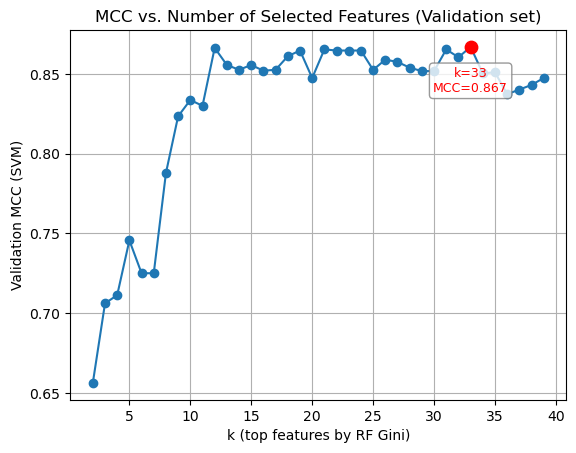

Test MCC score:  0.8128505915908301
----------------------------------------------------------------------------------------------------
Features by Gini importance for 2-th iteration:
               feature  importance
0           VhonHeijne    0.322601
1      tm_tendency_max    0.090002
2                    C    0.061006
3    max_miyazawa_mean    0.041642
4   chou_fasman_h_mean    0.034062
5      flexibility_max    0.023627
6                    R    0.020492
7            punta_max    0.020185
8             basicity    0.019145
9     flexibility_mean    0.018703
10       miyazawa_mean    0.017567
11      bulkiness_mean    0.016070
12                   T    0.016056
13    tm_tendency_mean    0.015656
14          punta_mean    0.015574
15    chou_fasma_b_max    0.015036
16          argos_mean    0.013870
17           argos_max    0.013109
18                   E    0.012995
19                   S    0.012909
20   chou_fasma_b_mean    0.012340
21   chou_fasman_h_max    0.012240
22        

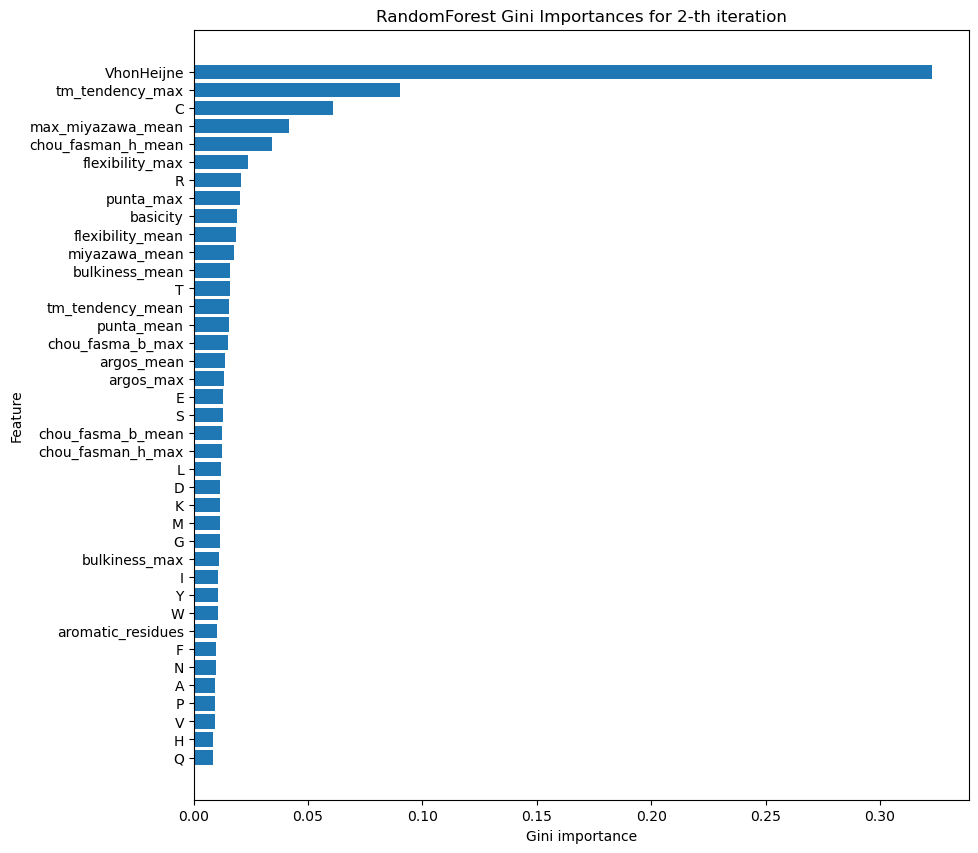

Best k on validation (using baseline best params): k=32, val_mcc=0.878


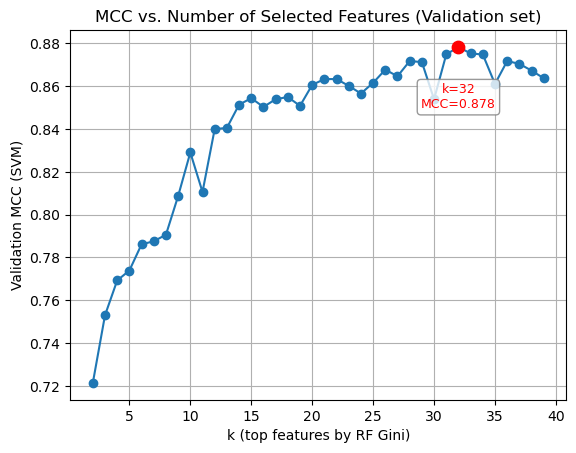

Test MCC score:  0.8509865741845943
----------------------------------------------------------------------------------------------------
Features by Gini importance for 3-th iteration:
               feature  importance
0           VhonHeijne    0.324552
1      tm_tendency_max    0.090510
2                    C    0.060680
3    max_miyazawa_mean    0.039557
4   chou_fasman_h_mean    0.034923
5                    R    0.023396
6             basicity    0.022673
7      flexibility_max    0.022194
8            punta_max    0.019715
9        miyazawa_mean    0.019548
10    flexibility_mean    0.019229
11      bulkiness_mean    0.017166
12    tm_tendency_mean    0.015706
13                   T    0.015318
14          punta_mean    0.015264
15    chou_fasma_b_max    0.014636
16          argos_mean    0.014444
17           argos_max    0.013985
18                   L    0.012559
19                   M    0.012258
20   chou_fasma_b_mean    0.011989
21                   S    0.011666
22       b

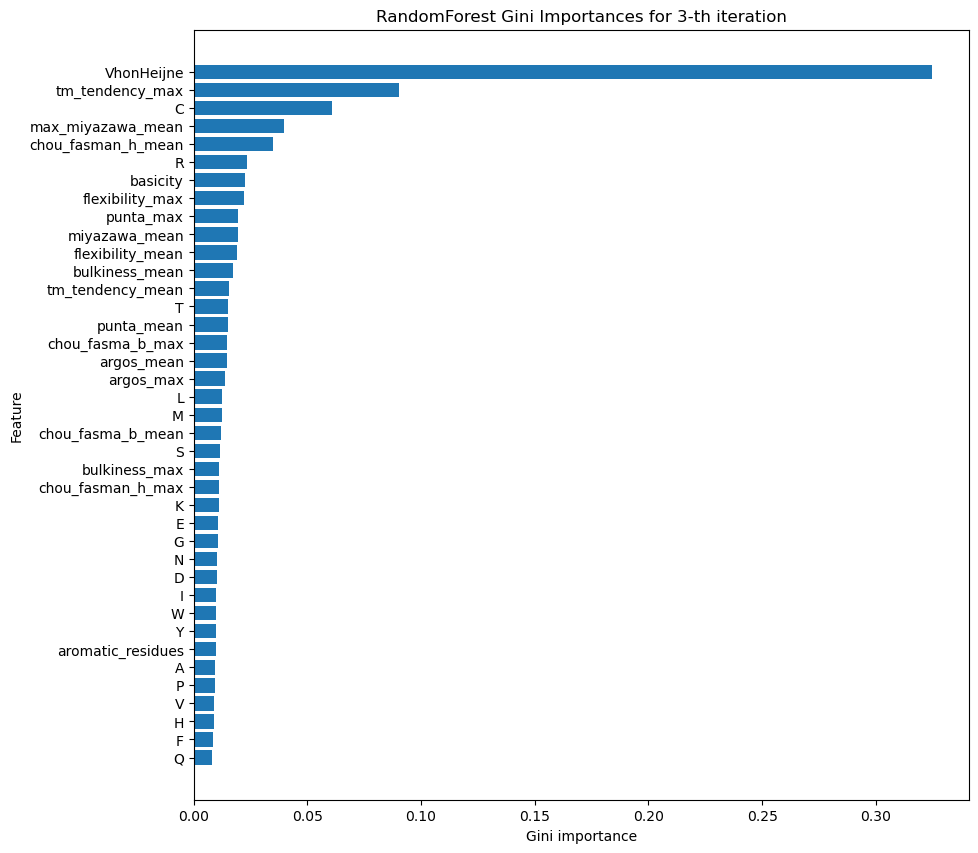

Best k on validation (using baseline best params): k=13, val_mcc=0.803


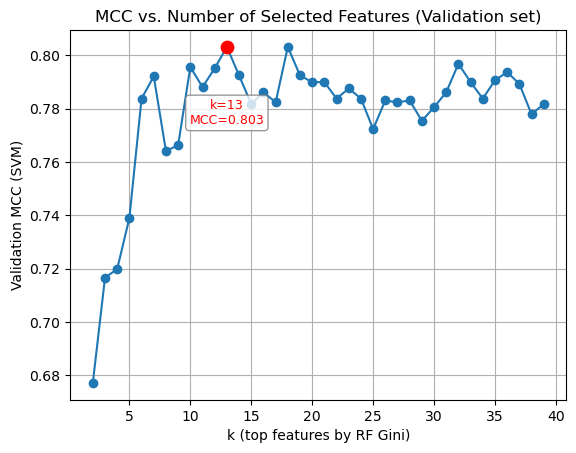

Test MCC score:  0.8694739008903419
----------------------------------------------------------------------------------------------------
Features by Gini importance for 4-th iteration:
               feature  importance
0           VhonHeijne    0.334877
1      tm_tendency_max    0.089715
2                    C    0.054951
3    max_miyazawa_mean    0.038591
4   chou_fasman_h_mean    0.037605
5             basicity    0.023374
6      flexibility_max    0.022074
7                    R    0.021353
8     flexibility_mean    0.021171
9            punta_max    0.020225
10      bulkiness_mean    0.018956
11    tm_tendency_mean    0.017074
12          punta_mean    0.015667
13       miyazawa_mean    0.015416
14                   T    0.015153
15    chou_fasma_b_max    0.014599
16          argos_mean    0.012615
17                   L    0.012486
18   chou_fasman_h_max    0.012225
19                   M    0.012099
20           argos_max    0.011861
21       bulkiness_max    0.011767
22   chou_

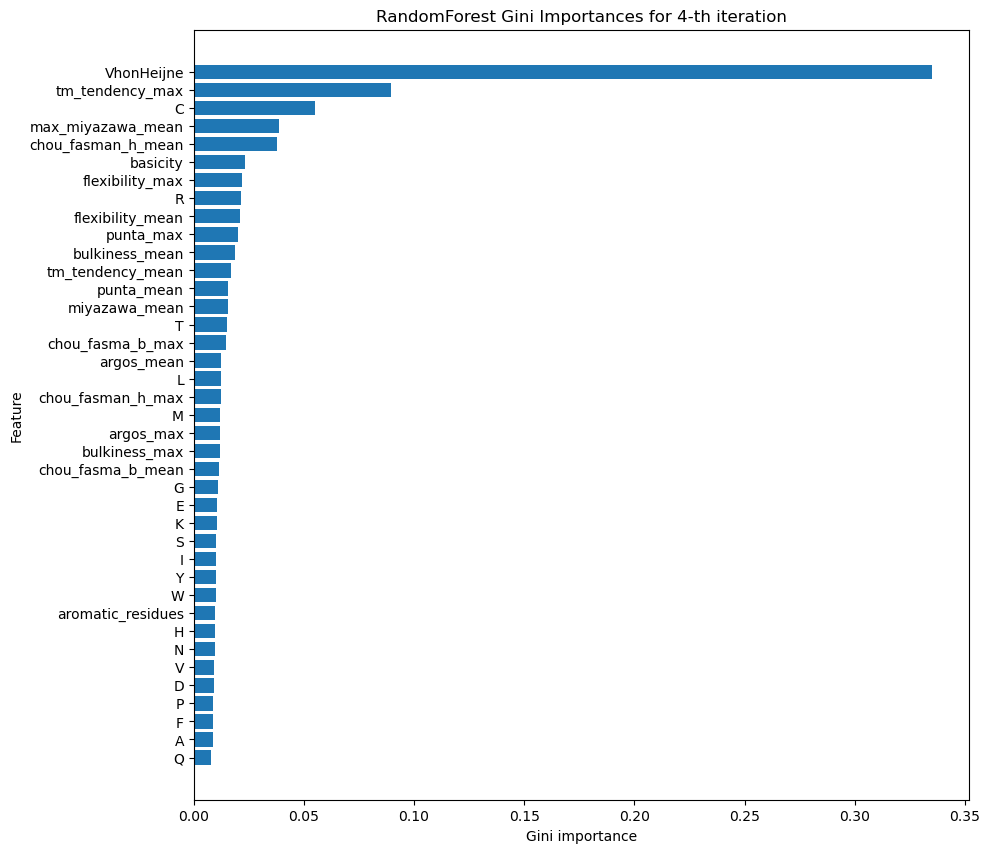

Best k on validation (using baseline best params): k=27, val_mcc=0.844


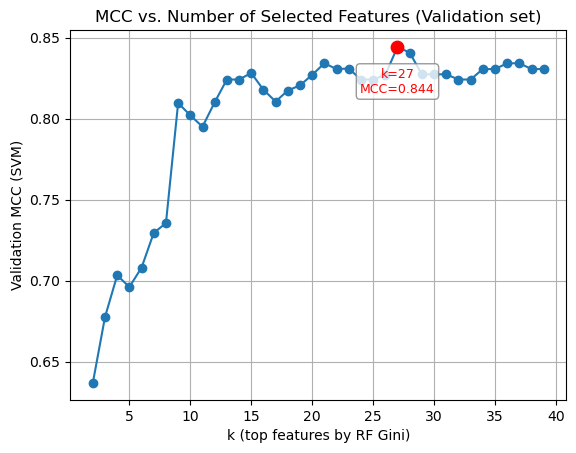

Test MCC score:  0.7913440822299024
----------------------------------------------------------------------------------------------------
Features by Gini importance for 5-th iteration:
               feature  importance
0           VhonHeijne    0.337495
1      tm_tendency_max    0.080697
2                    C    0.052023
3    max_miyazawa_mean    0.038681
4   chou_fasman_h_mean    0.036402
5             basicity    0.024486
6     flexibility_mean    0.022362
7      flexibility_max    0.022028
8     tm_tendency_mean    0.021015
9            punta_max    0.020886
10                   R    0.019337
11          punta_mean    0.015862
12      bulkiness_mean    0.015682
13       miyazawa_mean    0.015248
14                   T    0.014778
15   chou_fasman_h_max    0.014015
16                   G    0.013815
17                   L    0.013082
18    chou_fasma_b_max    0.013038
19          argos_mean    0.012715
20           argos_max    0.012202
21                   S    0.011929
22        

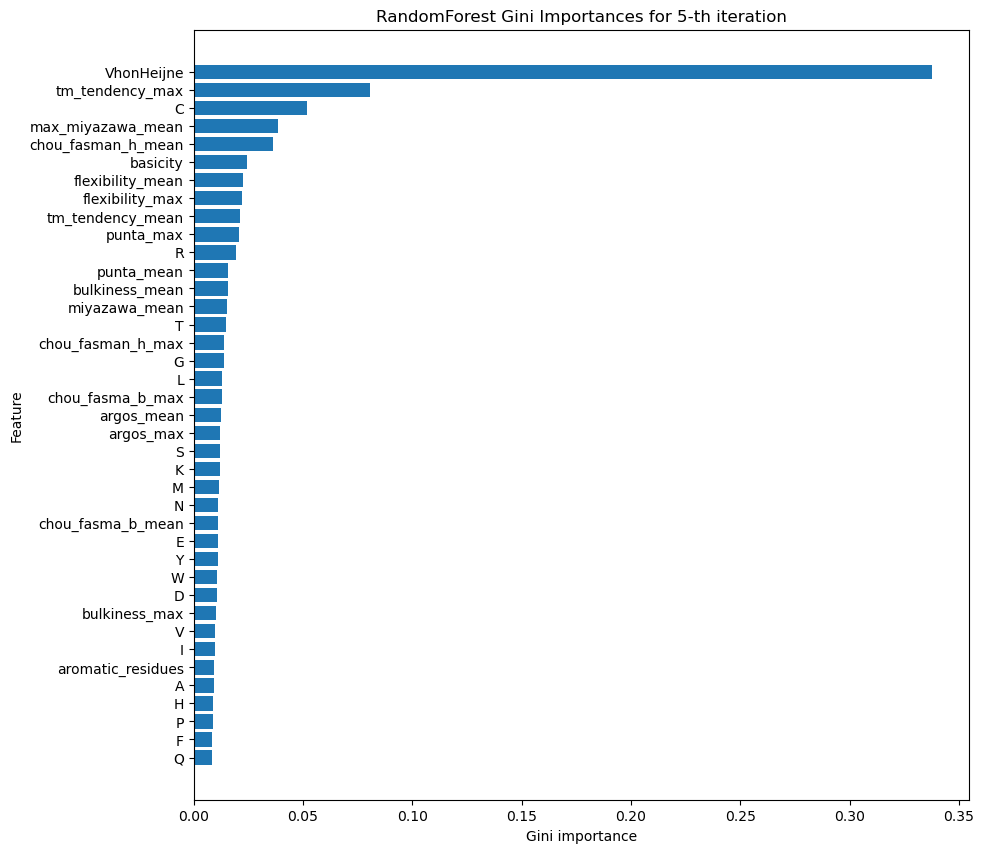

Best k on validation (using baseline best params): k=34, val_mcc=0.834


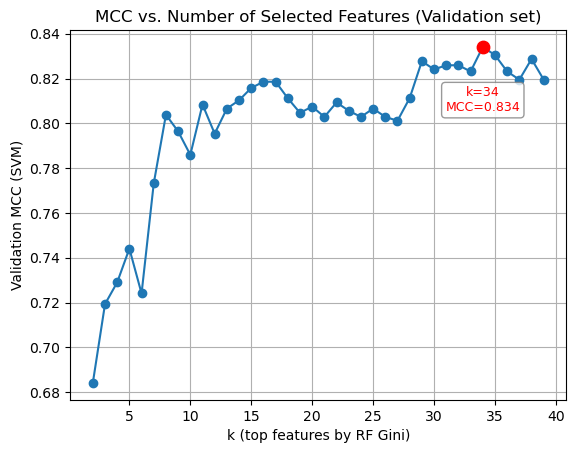

Test MCC score:  0.8273562203037476
----------------------------------------------------------------------------------------------------


In [5]:
# create a simple grid for initial SVM parameters
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

feature_counter={}
#create a Pipeline with StandardScaler to normalize data and SVC as predictor model
pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC())])
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=50) # construct the random forest classifier (-1 vuol dire utilizzare tutti i processori in parallelo). 


for i in range(1,6): #iteration on the sets 
    #Load the npz files of training, testing and validation sets for each iteration
    # load training
    loaded_data_train = np.load(f'training_features_{i}.npz')
    x_train = loaded_data_train['matrix']
    y_train = loaded_data_train['target']
    
    # load test
    loaded_data_test = np.load(f'testing_features_{i}.npz')
    x_test = loaded_data_test['matrix']
    y_test = loaded_data_test['target']
    
    # load validation
    loaded_data_validation = np.load(f'validation_features_{i}.npz')
    x_validation = loaded_data_validation['matrix']
    y_validation = loaded_data_validation['target']

    #INITIALIZING OF GAMMA AND C VALUES
    # grid search to set initial C and gamma parameters
    best_mcc=-1  #initialize mcc as -1
    # iterate over C and gamma we defined earlier
    for C in C_grid: 
        for gamma in gamma_grid:
            #use the pipeline we created earlier with rbf kernel
            pipeline.set_params(svm__kernel="rbf",svm__C=C , svm__gamma=gamma)
            pipeline.fit(x_train, y_train)  # fit on training data
            y_pred = pipeline.predict(x_test) # predict on test data
            mcc = matthews_corrcoef(y_test, y_pred) # compute MCC     
            # store parameter values that give best MCC
            if mcc > best_mcc:
                best_mcc = mcc
                best_params_base =  (C, gamma)
    pipeline.set_params(svm__kernel="rbf", svm__C=best_params_base[0], svm__gamma=best_params_base[1])
    rf.fit(x_train, y_train)  # fit on train data
    # create a Series with feature name and the corresponding feature importance based on Gini impurity
    gini_imp = pd.Series(rf.feature_importances_, index=feature_order_training).sort_values(ascending=False) 
    gini_df = gini_imp.reset_index()
    # name the columns
    gini_df.columns = ["feature", "importance"]
    print(f"Features by Gini importance for {i}-th iteration:")
    print(gini_df)

    # Plot the results
    plt.figure(figsize=(10, 10))
    plt.barh(gini_df["feature"][::-1], gini_df["importance"][::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Feature")
    plt.title(f"RandomForest Gini Importances for {i}-th iteration")
    plt.show()

    # FIND THE BEST NUMBER OF FEATURES (K)
    # create a list with all the features
    ks = list(range(2, x_train.shape[1]+1))
    curve = []
    
    #iterate over possible k-features
    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        mcc_k = performance_on_subset(subset, feature_order_training, x_train, y_train, x_validation, y_validation, pipeline)
        curve.append(mcc_k)
        
    # find the k that maximizes the MCC 
    best_k_idx = int(np.argmax(curve))
    best_k = ks[best_k_idx]

    #count how many times a feature appears in each iteration
    for feature in gini_df["feature"].head(best_k):
        feature_counter[feature] = feature_counter.get(feature, 0) + 1

    print(f"Best k on validation (using baseline best params): k={best_k}, val_mcc={curve[best_k_idx]:.3f}")
    
    #plot the MCC curve 
    plt.figure()
    plt.plot(ks, curve, marker="o")
    #highlight the best MCC 
    plt.scatter(best_k, curve[best_k_idx] , color="red", s=80, zorder=5)
    plt.text(best_k, curve[best_k_idx] - 0.03, f"k={best_k}\nMCC={curve[best_k_idx]:.3f}",
         ha="center", va="bottom", fontsize=9, color="red", bbox=dict(
        facecolor="white",   # colore di sfondo
        alpha=0.8,           # trasparenza (1=opaco)
        edgecolor="gray",    # colore del bordo
        boxstyle="round,pad=0.3"  # forma del riquadro ("round" o "square")
    ))
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation MCC (SVM)")
    plt.title("MCC vs. Number of Selected Features (Validation set)")
    plt.grid(True)
    plt.show()

    #TESTING PROCEDURE
    # Use the best k from the validation curve to perform the testing procedure
    best_subset = gini_df["feature"].head(best_k).tolist()
    idx = [feature_order_training.index(f) for f in best_subset]
    #recover the most informative features from the training set (useful for grid search) and the testing set. 
    Xtr_sel = x_train[:, idx]
    Xte_sel = x_test[:, idx]
    Xva_sel = x_validation[:, idx]
    # Manual grid search again but now restricted to the selected features
    best_score_sel = -np.inf
    best_params_sel = None
    
    # grid search iterations
    for C in C_grid:
        for gamma in gamma_grid:
            pipeline.set_params(svm__kernel="rbf",svm__C=C , svm__gamma=gamma)
            pipeline.fit(Xtr_sel, y_train)      # train on TRAIN
            val_mcc = pipeline.score(Xva_sel, y_validation)  # validate on VAL
            if val_mcc > best_score_sel:
                best_score_sel = val_mcc
                best_params_sel =(C,gamma)
    #set the SVM with the best parameters found in the grid search 
    pipeline.set_params(svm__kernel="rbf", svm__C=best_params_base[0], svm__gamma=best_params_base[1])
    #train the SVM with the restricted features
    pipeline.fit(Xtr_sel, y_train) 
    # predict on test data
    y_pred_sel = pipeline.predict(Xte_sel)
    # compute MCC
    mcc = matthews_corrcoef(y_test, y_pred_sel)
    
    print("Test MCC score: ", mcc)
    print("-"*100)

In [6]:
#Select the features that we will use for training the final model
features_to_use= [k for k, v in feature_counter.items() if v > 4]
print("Feature to use: "+ str(features_to_use)+ "\n"+"Number of features: "+ str(len(features_to_use)))


Feature to use: ['VhonHeijne', 'tm_tendency_max', 'C', 'max_miyazawa_mean', 'chou_fasman_h_mean', 'flexibility_max', 'punta_max', 'flexibility_mean', 'basicity', 'tm_tendency_mean', 'R', 'miyazawa_mean', 'bulkiness_mean']
Number of features: 13
